In [1]:
%pylab inline
import webbpsf, astropy

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# JWST Using Wavefronts Measured On Orbit


WebbPSF now includes code for using the results of in-flight wavefront sensing measurements, by retrieving Optical Path Difference (OPD) files which include the sensing results for the positions of the mirrors at different times. These are produced by the JWST Wavefront Sensing Subsystem (WSS), using focus diverse phase retrieval on NIRCam weak lens data taken roughly every two days in flight. The output OPDs from that are saved in MAST and can be automatically retrieved and used in WebbPSF. 

Begin by instantiating an instrument instance in the usual manner. In this case, let's set up a NIRCam instance for one of the detectors in module B. 

In [2]:
nrc = webbpsf.NIRCam()
nrc.filter='F200W'

nrc.detector = 'NRCB2'
nrc.detector_position = (1024,1024)

### Finding the measured wavefront near a given date

To load an OPD corresponding to observations on some particular date, use the method `load_wss_opd_by_date`. This takes as its first argument a date time specified in ISO format, like "YYYY-MM-DDTHH:MM:SS".  

Let's also set `plot=True` so this makes a plot which shows what's going on.


MAST OPD query around UTC: 2022-07-01T00:00:00.000
                        MJD: 59761.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022063002-NRCA3_FP1-2.fits
	Date (MJD):	 59759.6628
	Delta time:	 -1.3372 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022070403-NRCA3_FP1-0.fits
	Date (MJD):	 59761.5484
	Delta time:	 0.5484 days
User requested choosing OPD time closest in time to 2022-07-01T00:00:00.000, which is R2022070403-NRCA3_FP1-0.fits, delta time 0.548 days
Importing and format-converting OPD from /Users/mperrin/software/webbpsf-data/MAST_JWST_WSS_OPDs/R2022070403-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


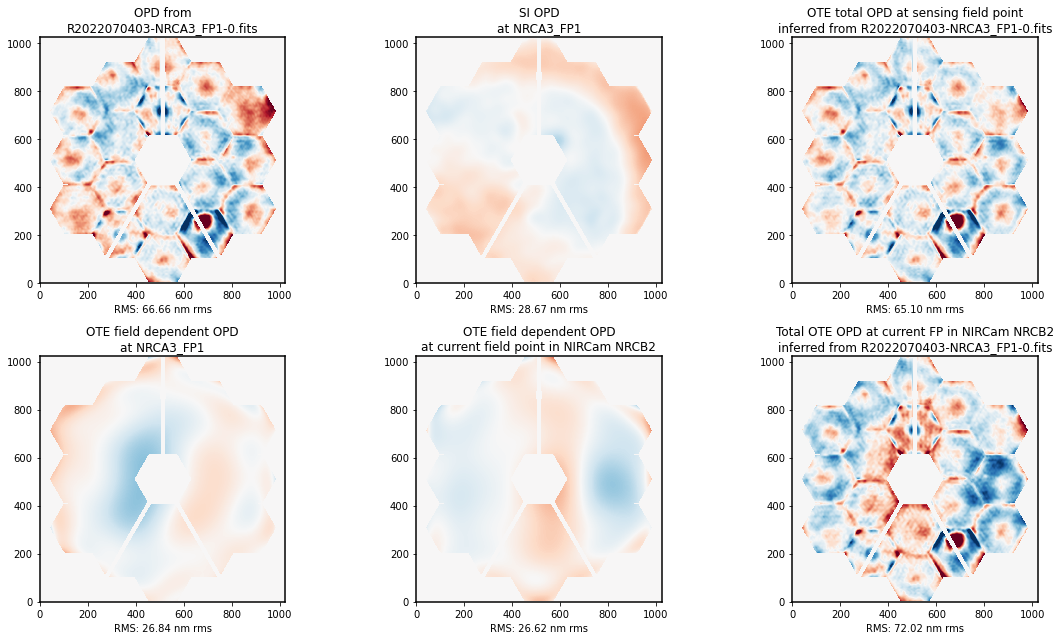

In [3]:
nrc.load_wss_opd_by_date('2022-07-01T00:00:00',plot=True)

Given the input date, the function queries to find the closest-in-time wavefront sensing result. In this case it is a measurement about 0.5 days after the specified time. (You can set keyword `choice='before'` or `choice='after'` if you have some reason to specify which in particular).  That OPD file will be automatically retrievd from MAST; downloads are cached inside your $WEBBPSF_DATA_PATH directory for reuse in multiple calculations.

Let's look at each plot in turn. 

* **Upper Left:** This is the measured OPD as sensed in NIRCam at "field point 1" which is in the upper left corner of NRCA3, relatively close to the center of the NIRCam module. This observatory total OPD measurement includes both the telescope and NIRCam contributions to the WFE.
* **Upper Middle:** This is the wavefront map for the NIRCam portion of the WFE at that field point. This is known from ground calibration test data, not measured in flight. 
* **Upper Right:** That NIRCam WFE contribution is subtracted from the total observatory WFE to yield this estimate of the OTE-only portion of the WFE.
* **Lower Left and Middle:** These are models for the field dependence of the OTE OPD between the sensing field point in NRCA3 and the requested field ooint, in this case in NRCB2. This field dependence arises mostly from the figure of the tertiary mirror. These are used to transform the estimated OTE OPD from one field position to another. 
* **Lower Right**: This is the resulting estimate for the OTE OPD at the requested field point, in this case in NRCB2. 

All those calculations happen automatically as part of the `load_wss_opd_by_date` (inside the `load_wss_opd` function which it calls in turn). 


After that it's just a matter of calculating PSFs as usual: 

In [4]:
psf = nrc.calc_psf(fov_pixels=101)

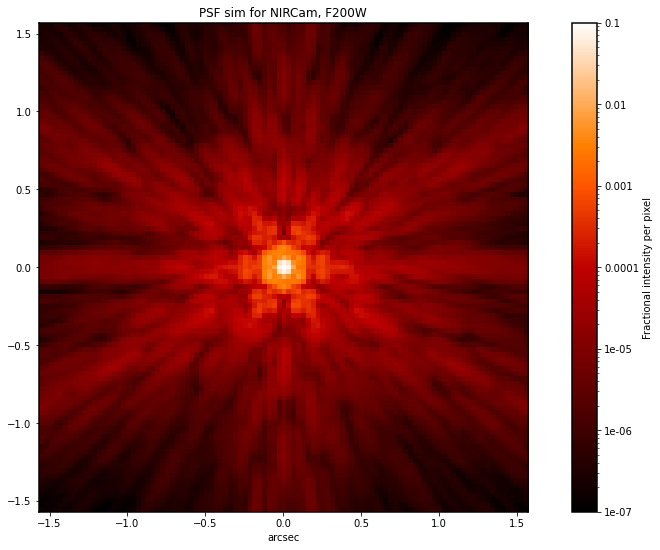

In [5]:
plt.figure(figsize=(16,9))
webbpsf.display_psf(psf, ext=1)

Thus, the above PSF is calculated using the actual as-measured-at-L2 state of the telescope WFE near the requested date, in this case 2022 July 1. 

### Loading a particular OPD file

If you already know the filename of a particular desired OPD file, you can simply retrieve it by name using the `load_wss_opd` function. Once again, this file will be automatically retrieved from MAST if necessary. 

Importing and format-converting OPD from /Users/mperrin/software/webbpsf-data/MAST_JWST_WSS_OPDs/O2022073001-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


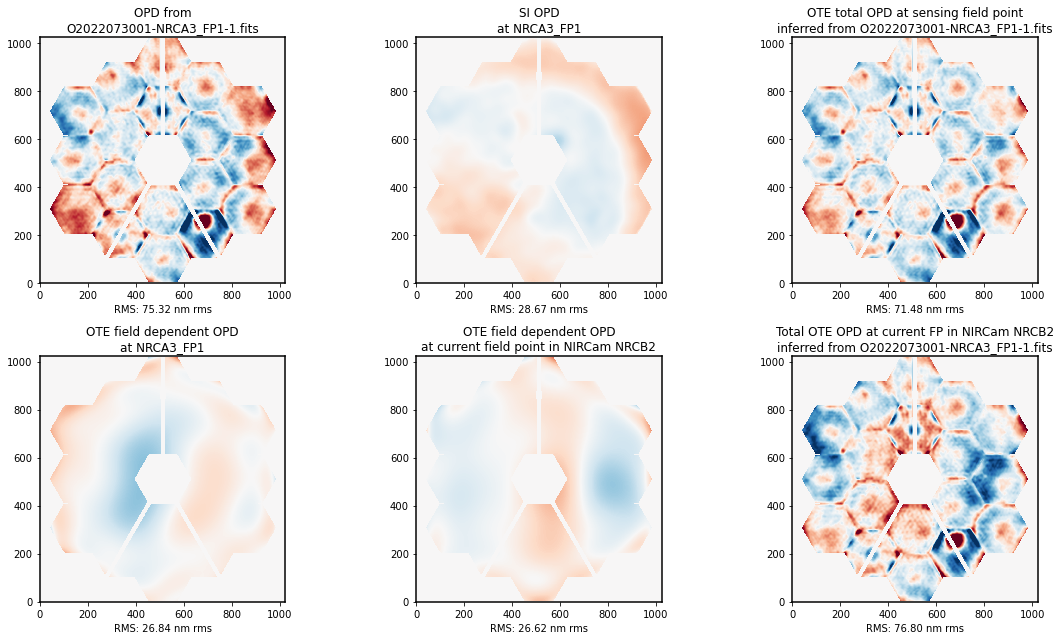

In [3]:
nrc.load_wss_opd("O2022073001-NRCA3_FP1-1.fits", plot=True)

## Trending Wavefront Changes over Time

To help observers understand how the mirror alignments change over time, and when such changes might affect  PSFs in science data, WebbPSF also includes some functions for generating trending plots showing wavefronts over time. 

These functions work by downloading sets of several OPDs from MAST, and performing calculations such as inferring the changes between one measurement and the next. 


### Wavefront Trending throughout a given month

A wavefront trending plot can be produced that shows wavefront changes during some particular month of interest:

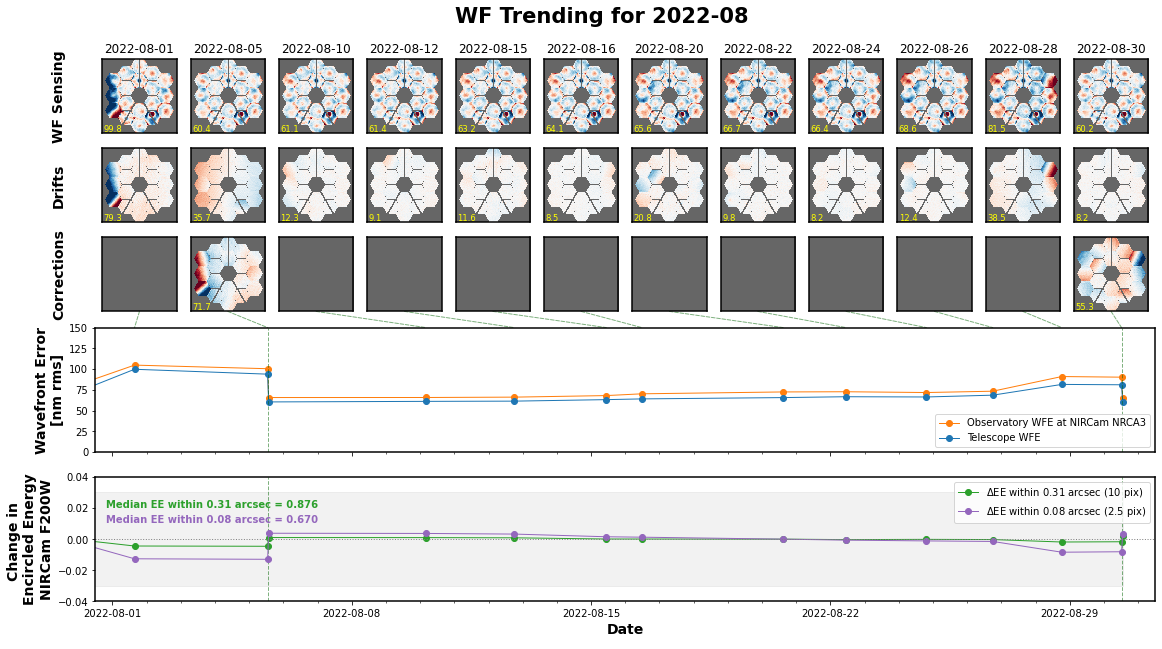

In [3]:
trend_table = webbpsf.trending.monthly_trending_plot(2022, 8, verbose=False)

The above figure shows: 

 * Each wavefront sensing measurement throughout the specified month (first row)
 * The drift in wavefront between each two successive measurements (i.e. the changes arising in the telescope itself, without any ground commanding. Second row)
 * The mirror corrections applied (i.e. the result of mirror move commands sent from the ground. Third row)
 * Plots of the wavefront RMS value over time, for both the OTE wavefront only (i.e. the waveront quality from the telescope delivered to the NIRCam sensing field point) and the total observatory wavefront (i.e. the sum of telescope and instrument contributions to the wavefront). 
 * Computed values for the encircled energy within radii of 2.5 pixels and 10 pixels, and their variation over time. 
 
In the above plot for 2022 July, we can see that the wavefront was generally stable (very little change from one meaurement to the next, but a few individual mirror tilt events can be seen for instance in the July 4 and July 6 sensing). A wavefront correction was applied on July 8. Then the July 12 wavefront sensing revealed a  larger wing tilt event affecting the several segments on the left (-V2) wing. This was corrected in the July 15 wavefront sensing and control observation, and after that the telescope remained stable throughout the rest of that month's wavefront sensing. 

The `monthly_trending_plot` function automatically saves the plot as a PDF to the current working directory, with filenames like "`wf_trending_2022-08.pdf'`"


The function also returns a table with information summarizing the available WFS measurements, WFE levels, and computed PSF encircle energies. This can be used to help understand how much the photometry in your observation is affected by PSF changes at a given time. 

In [4]:
trend_table

Date,Filename,WFS Type,RMS WFE (OTE+SI),RMS WFE (OTE only),EE(2.5 pix),EE(10pix)
,,,nm,nm,,
str23,str29,str16,float64,float64,float64,float64
2022-07-30T14:16:12.800,O2022073001-NRCA3_FP1-1.fits,Sensing,75.3218690264774,66.09542450712576,0.6696332020294565,0.8767156339082203
2022-08-01T15:29:51.000,O2022080201-NRCA3_FP1-0.fits,Sensing,104.78028354828677,99.77286800716806,0.6569210392491929,0.8716854918129445
2022-08-05T12:55:58.900,R2022080601-NRCA3_FP1-0.fits,Sensing,100.43731215562515,93.88799015744388,0.6565941724030266,0.8715130503124521
2022-08-05T13:38:34.300,R2022080601-NRCA3_FP1-1.fits,Post Mirror Move,65.70009131907837,60.41040935551668,0.6733419027570456,0.8771249633140422
2022-08-10T04:06:35.800,R2022081102-NRCA3_FP1-1.fits,Sensing,65.7455043858421,61.08067782976896,0.6732164429302696,0.8770853234542049
2022-08-12T17:58:37.000,O2022081401-NRCA3_FP1-1.fits,Sensing,66.18345915687821,61.35862651863206,0.672807234955758,0.8769571339901217
2022-08-15T10:41:30.900,O2022081601-NRCA3_FP1-1.fits,Sensing,68.05351480352284,63.17040406499793,0.671085164794359,0.8761902354255183
2022-08-16T11:38:59.500,O2022081602-NRCA3_FP1-1.fits,Sensing,70.1897000850969,64.05438013560472,0.6708090590535625,0.87618409429269


By default, the trending table performs computations of the encircled energy for NIRCam F200W, but you can specify a different instrument and filter if so desired. 

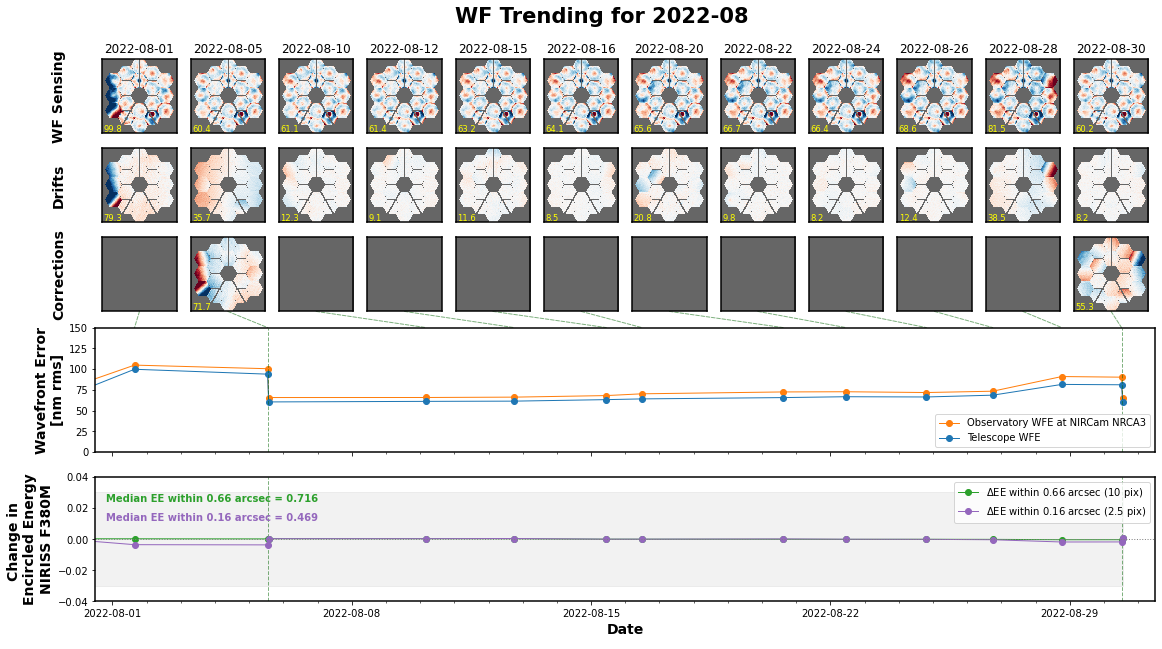

In [6]:
webbpsf.trending.monthly_trending_plot(2022, 8, verbose=False, instrument='NIRISS', filter='F380M'); 

## Wavefront time series and histogram plots

Other functions can provide views of wavefront changes over even longer timescales. We can retrieve a table of all available OPDs and plot the measurements over time:

In [5]:
opdtable = webbpsf.mast_wss.retrieve_mast_opd_table()
opdtable = webbpsf.mast_wss.deduplicate_opd_table(opdtable)
webbpsf.mast_wss.download_all_opds(opdtable)

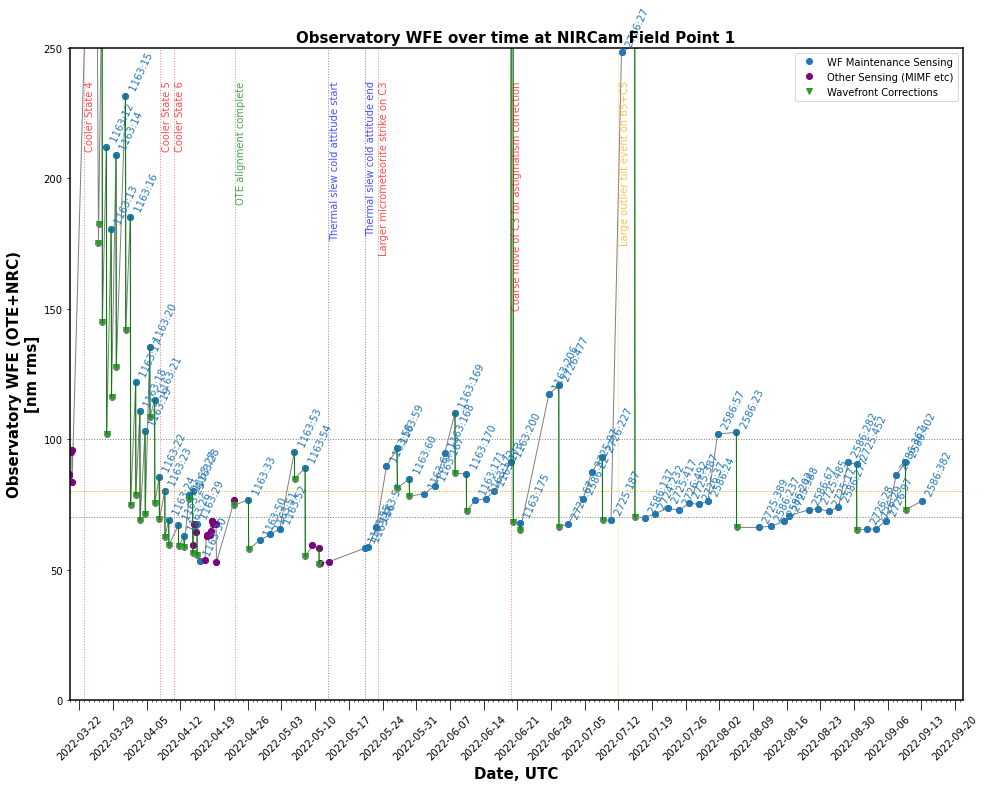

In [6]:
webbpsf.trending.wavefront_time_series_plot(opdtable)

The above shows wavefront drifts and corrections from around the middle of OTE commissioning to the early part of Cycle 1.  Rapid drifts and corrections in early March are from the MIRI cryocooler gradually cooling the observatory, until reaching thermal stability in mid April. 

Occasional increases in wavefront error from mirror tilts and corrections can be seen in subsequent months.  There was an especially large tilt event on July 12, which was corrected on July 15. 

We can also plot all measured wavefront drifts over specified time periods. 

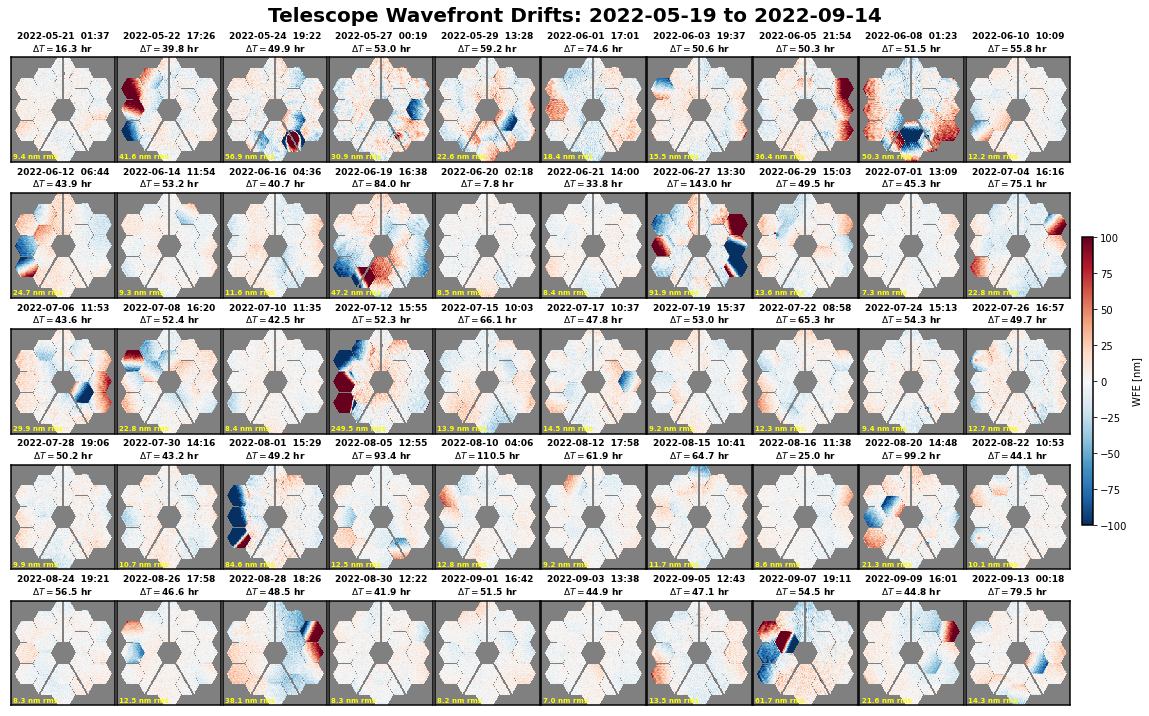

In [11]:
start_time =  astropy.time.Time('2022-05-19T00:00:00')
end_time = astropy.time.Time.now()

webbpsf.trending.wavefront_drift_plots(opdtable, start_time=start_time, end_time=end_time, n_per_row=10)

Lastly, we can plot histograms of wavefront error levels over time.

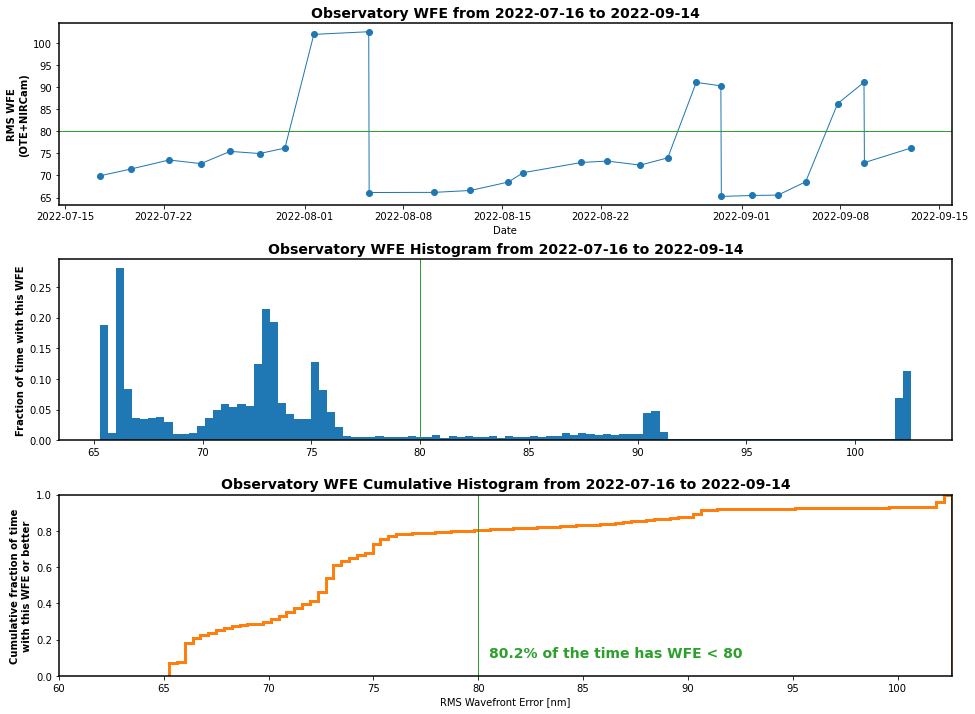

In [10]:
start_time =  astropy.time.Time('2022-07-16')
webbpsf.trending.wfe_histogram_plot(opdtable, thresh=80)